# 5. Regresja

Regrasja polega na stworzeniu modelu opisującego zależność między zmiennymi. Posiadając taki model możemy przewidywać wartość  jednej zmiennej ciągłej na podstawie innych zmienneych. 

Poniższy notatnik demonstruje:
1. Metody **regresji liniowej** i wielomianowej z użyciem pakietu scikit-learn
2. Tworzenie modelu (`fit`), predykcję wartości (`predict`) oraz ocenę jakości predykcji (miary MSE. $R^2$-score)
3. **Problem przeuczenia** (_overfitting_) oraz sposoby redukcji tego problemu za pomocą **regularyzacji**


## Generowanie danych treningowych

Stworzymy najpierw sztuczne dane, na których zbudujemy model regresyjny


In [1]:
import numpy as np
import matplotlib.pyplot as plt

Zdefinujmy funkcję `true_function()`, która posłuży do wygenerowania danych do których będziemy dopasowywali nasz model. 

$$ f(x) = \cos \left(1.5 \cdot \pi \cdot  x\right) $$

In [2]:
def true_function(x):
    return np.cos(1.5 * np.pi * x)

Wygenerujmy próbkę danych `x` oraz wyznaczmy wartości funkcji `y` dla tych danych.   
Będziemy szukać zależności `x ~ y`


Zainicjalizujmy najpierw ziarno dla funkcji losującej, aby za każdym razem otrzymać *te same* ale losowe dane. Często się to przydaje, gdy operujemy na losowych danych, ale chcemy zagwarantować powtarzalność wyników. 

In [3]:
np.random.seed(0)

In [4]:
n_samples = 30
x = np.sort(np.random.rand(n_samples, 1))
y = true_function(x) 

Narysujmy tą funkcję oraz wygenerowane punkty.

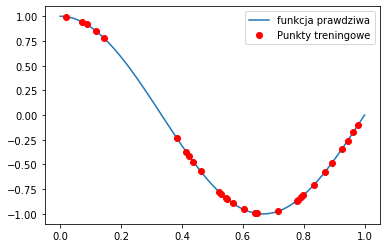

In [5]:
#przedział do 'gęstego' narysowania funkcji,
x_range = np.linspace(0, 1, 100)

# operacja reshape tworzy transpozycje wektora, otrzymujemy macierzy o wymiarach (100, 1), 
# taka postać jest wymagana później przez model regresyjny LinearRegression()
x_range = np.reshape(x_range, (-1, 1))

plt.plot(x_range, true_function(x_range), label='funkcja prawdziwa')
plt.plot(x, y, 'ro', label='Punkty treningowe')
plt.legend()
plt.show()

Dodajmy trochę szumu do danych aby utrudnić problem dopasowania modelu w naszym przykładzie. 

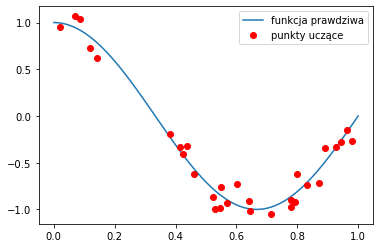

In [6]:
y = true_function(x) + np.random.randn(n_samples, 1) * 0.1

plt.plot(x_range, true_function(x_range))

plt.plot(x, y, 'ro',)
plt.legend(['funkcja prawdziwa','punkty uczące'])
plt.show()

## Model liniowy

Dopasujmy do naszych danych model liniowy dla jednej zmiennej 

$$ f(x) = x w_1 + w_0 $$

Zadanie polega na znalezieniu takich parametrów $w_1$ i $w_0$ definiujących linię aby błąd popełniany przez tą funkcję był jak najmniejszy, tzn. chcemy aby punkty danych leżały w jak najmniejszej odległości od dopasowanej linii.  Funkcja kosztu (błędu) to suma kwadratów różnic między punktem prawdziwym $y_i$ a tym uzyskanym z modelu $f(x_i)$:

$$L(y, f(x,w)) = \sum_{i=1}^N \|y_i - f(x_i)\|^2,$$

Zadanie polega więc na znalezieniu takich $w_1$ i $w_0$, które minimalizują wartość błędu $L$. W celu wyznaczenia tego minimum wykorzystamy algorytm regresji liniowej dostępny w pakiecie scikit-learn dla klasy [LinearRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

## Regresja wielu zmiennych 

Ogólna postać modelu regrasji liniowej wielowymiarowej  

$$
\begin{array}{ll}
f(\mathbf{x}) & = x_1 w_1 + x_2 w_2 + \ldots + x_k w_k + w_0 \\
              & = \mathbf{x}^T \mathbf{w} + w_0 \\
\end{array}
$$

gdzie dla $k$ zmiennych $\mathbf{w}$ jest wektorem współczynników $[w_1, w_2, \ldots, w_k]$   i wraz z wyrazem wolnym $w_0$ są szukanymi wartościami określającymi liniową zależność w przestrzeni $\mathbb{R}^k$ 

## Liniowa regresja w scikit-learn

In [7]:
from sklearn.linear_model import LinearRegression

# Tworzymy obiekt realizujący liniową regresję
regr = LinearRegression()

Metoda ``fit(x, y)`` modelu predykcyjnego uruchamia trening modelu

In [8]:
# Dopasowanie modelu do danych (poszukiwanie minimum funkcji błedu)
regr.fit(x, y)

# Wyznaczone wspólczynniki regresji
a = regr.coef_[0]           # wspólczynnik kierunkowy  
b = regr.intercept_         # wyraz wolny w_0

print("f(x) = %f x + %f" % (a, b))

f(x) = -1.528984 x + 0.490000


## Predykcja

Metoda [predict()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) pozwala wyznaczyć przewidywaną wartość zmiennej wyjściowej dla dowonych wartości wejściowych `x` 

In [9]:
y1 = regr.predict([[0.5]])
print(y1)

[[-0.27449182]]


In [10]:
# to samo
print(a * 0.5 + b)  

[-0.27449182]


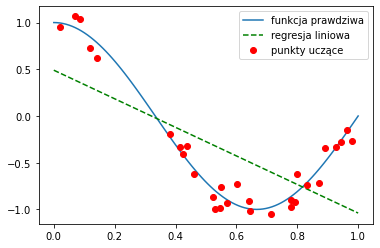

In [11]:
y_pred = regr.predict(x_range)

plt.plot(x_range, true_function(x_range), label='funkcja prawdziwa')
plt.plot(x_range, y_pred, 'g--', label='regresja liniowa')
plt.plot(x, y, 'ro', label='punkty uczące')
plt.legend()
plt.show()

In [12]:
# co sprowadza się w tym przypadku do operacji
y_lin = a * x_range + b      # model liniowy zalezosci X ~ Y

np.alltrue(y_pred == y_lin)

True

## Regresja wielomianowa

Model liniowy w tym przypadku jest daleki od ideału. Spróbujmy dopasować do danych funkcję wielomianową.

$$ f(x) = x^k w_k + x^{k-1} w_{k-1} + \ldots + x w_1 + w_0 $$

gdzie $k$ określa stopień wielomianu.  
Dla $k=1$ otrzymamy znowu model liniowy, dla $k=2$ parabolę, itd.

Jak widać sprowadza się to do znalezienia wspólczynników $w_i$ liniowego modelu dla $k$ zmiennych, gdzie zmienne są postaci $x, x^2, \ldots, x^k$.

Wykorzystajmy funkcję [PolynomialFeatures()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) do przekształcenia danych $x$ do takiej postaci.

### Transformacja wielomianowa w scikit-learn

Stwórzmy model liniowy dla zmiennych $(x^2, x, 1)$, co odpowiada dopasowaniu wielomianu 2 stopnia $$f(x) = w_2 x^2 + w_1 x + w_0$$

[PolynomialFeatures()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) jest transformatorem danych, API takich modeli w scikit-learn wygląda tak: 
* ``fit(x)`` - trening (dopasowanie) modelu transformacji na danych treningowych
* ``transform(x)`` - transformacja (nowych) danych za pomocą modelu uzyskanego w treningu
* ``fit_transform(x)`` - trening i transformacja danych treningowych 

In [13]:
from sklearn.preprocessing import PolynomialFeatures 

# transformacja wielomianowa stopnia 2 
poly2 = PolynomialFeatures(degree = 2) 
x_poly2 = poly2.fit_transform(x)

print(x.shape, '-> ', x_poly2.shape)
print(x[0], ' -> ', x_poly2[0])

(30, 1) ->  (30, 3)
[0.5488135]  ->  [1.         0.5488135  0.30119626]


 Zmienna $x_i$ zostaje zamieniona na $1, x_i, x_i^2$

In [14]:
# sprawdźmy 
x_tmp =  np.hstack( [ np.ones(x.shape), x, x*x] )   #  x zamienione na 1, x, x^2
np.alltrue(x_tmp == x_poly2)

True

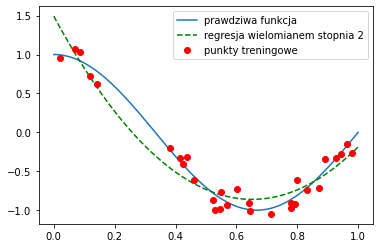

3 współczynniki regresji: [ 0.         -7.22320162  5.54394015]


In [15]:
regr2 = LinearRegression()
regr2.fit(x_poly2, y)

plt.plot(x_range, true_function(x_range), label='prawdziwa funkcja')
plt.plot(x_range, regr2.predict(poly2.transform(x_range)), 'g--', label='regresja wielomianem stopnia 2')
plt.plot(x, y, 'ro', label='punkty treningowe')
plt.legend()
plt.show()

print('%d współczynniki regresji: %s'  % ( len(regr2.coef_[0]), str(regr2.coef_[0])))

Wynik wygląda lepiej. Spróbujmy dopasować wielomian wyższego rzędu.

### Dopasowanie wielomianu stopnia 3

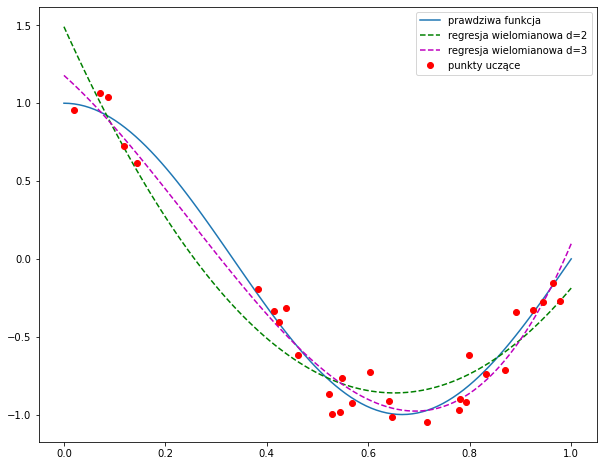

4 współczynniki regresji: [ 0.         -2.91056092 -5.075857    6.9047983 ]


In [16]:
poly3 = PolynomialFeatures(degree = 3) 
x_poly3 = poly3.fit_transform(x) 

regr3 = LinearRegression()
regr3.fit(x_poly3, y)

plt.figure(figsize=(10,8))
plt.plot(x_range, true_function(x_range), label='prawdziwa funkcja')
plt.plot(x_range, regr2.predict(poly2.transform(x_range)), 'g--', label='regresja wielomianowa d=2')
plt.plot(x_range, regr3.predict(poly3.transform(x_range)), 'm--', label='regresja wielomianowa d=3')
plt.plot(x, y, 'ro', label='punkty uczące')
plt.legend()
plt.show()

print('%d współczynniki regresji: %s'  % ( len(regr3.coef_[0]), str(regr3.coef_[0])))

## Przeuczenie

Wygląda na to, że jeśli będziemy dopasowywać wielomian coraz wyższego stopnia, otrzymamy coraz lepszą aproksymację danych. Niemniej jednak zwiększanie stopnia wielomianu, a co za tym idzie 'poziomu skomplikowania' naszego modelu, będzie powodować zbyt duże dopasowanie się do danych i zbyt małe możliwości generalizacji modelu. W szczególności możemy mówić o dwóch fenomenach jeżeli uczymy się parametrów modelu z danych:

* **underfit** - model jest zbyt 'prosty' aby uchwycić zależności między danymi
* **overfit** (przeczenie)  - parametry naszego modelu 'nauczyły' się szumu, model jest zbyt dopasowany do danych treningowych

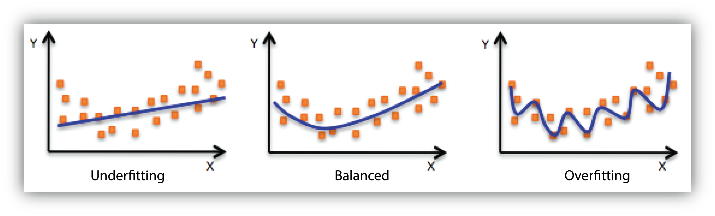


Istnieje zatem całkiem duże prawdopodobieństwo, że zwiększając stopień wielomianu dopasowaliśmy wielomian do szumu. Aby to zilustrować weźmy wielomian 16-go stopnia:

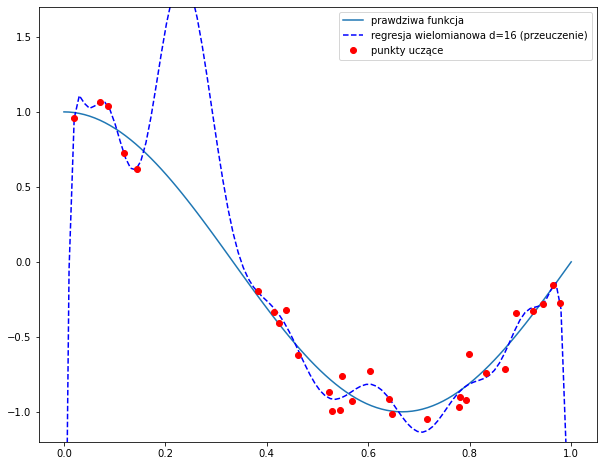

17 współczynników regresji: [ 0.00000000e+00  5.20451280e+02 -2.43726233e+04  6.05410643e+05
 -9.00633802e+06  8.61765708e+07 -5.58108804e+08  2.53971135e+09
 -8.33535921e+09  2.00536293e+10 -3.56208182e+10  4.66184867e+10
 -4.43743183e+10  2.98671392e+10 -1.34693359e+10  3.65075496e+09
 -4.49532856e+08]


In [17]:
poly16 = PolynomialFeatures(degree = 16)
x_poly16 = poly16.fit_transform(x)

regr16 = LinearRegression() 
regr16.fit(x_poly16, y)

plt.figure(figsize=(10,8))
plt.plot(x_range, true_function(x_range), label='prawdziwa funkcja')
plt.plot(x_range, regr16.predict(poly16.fit_transform(x_range)), 'b--', label='regresja wielomianowa d=16 (przeuczenie)')
plt.plot(x, y, 'ro', label='punkty uczące')
plt.ylim((-1.2, 1.7))
plt.legend()
plt.show()

print('%d współczynników regresji: %s'  % ( len(regr16.coef_[0]), str(regr16.coef_[0])))

## Ocena modelu
### Błąd MSE

Podstawową miarą służącą do oceny modelu regresyjnego jest średnia wartość funkcji kosztu, czyli tzw. **błąd średniokwadratowy MSE** (*mean squared error*):

$$ MSE = \frac{1}{n} \sum_{i=1}^n \left( y_i - f(x_i) \right)^2 $$

W przypadku idealnego dopasowania, gdy wszystkie $y_i$ są bezbłędnie dopasowane przez funkcję $f(x_i)$, bład MSE ma wartość 0. 

### Miara $R^2$

Drugą powszechnie używaną miarą oceny jest **współczynnik determinacji $R^2$**:

$$ R^2 = \frac{\sum_{i=1}^n \left( f(x_i) - \bar{y}_i\right)^2}{\sum_{i=1}^n \left( y_i - \bar{y}_i\right)^2} > 0$$

gdzie $\bar{y}$ to średnia wartość odpowiedzi $y_i$ dla wszystkich punktów w danych $i=1,\ldots,n$.  

Im większa wartość współczynnika $R^2$ tym lepsze dopasowanie $f(x)$ do danych.

W przypadku bezbłędnego dopasowania $R^2=1$.

### Meryki oceny w scikit-learn

Pakiet ``sklearn.metrics`` zawiera szereg metryk do oceny modeli, w tym do oceny modeli regresyjnych:
* funkcja ``mean_squared_error(y_true, y_pred)``
* funkcja ``r2_score(y_true, y_pred)``

Modele predykcyjne posiadają też metodę ``score(x, y)`` do wyznaczania oceny (dla ``LinearRegression()`` domyślnie jest to miara $R^2$) 

In [18]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = regr.predict(x)
y_regr2_pred = regr2.predict(poly2.transform(x))
y_regr3_pred = regr3.predict(poly3.transform(x))
y_regr16_pred = regr16.predict(poly16.transform(x))

import pandas as pd

columns = ['Model', 'MSE', 'R2']
data = pd.DataFrame(columns=columns)
data.loc[0] = ['linear',   mean_squared_error(y, y_pred),        r2_score(y, y_pred)        ] 
data.loc[1] = ['poly 2',   mean_squared_error(y, y_regr2_pred),  r2_score(y, y_regr2_pred)  ] 
data.loc[2] = ['poly 3',   mean_squared_error(y, y_regr3_pred),  r2_score(y, y_regr3_pred)  ] 
data.loc[3] = ['poly 16',  mean_squared_error(y, y_regr16_pred), r2_score(y, y_regr16_pred) ] 

data

,Model,MSE,R2
0,linear,0.221991,0.452553
1,poly 2,0.026898,0.933666
2,poly 3,0.014699,0.963751
3,poly 16,0.005255,0.987041


In [19]:
# R2-score za pomoca metody score() modelu
regr.score(x, y)

0.4525526854808549

<AxesSubplot:xlabel='Model', ylabel='MSE'>

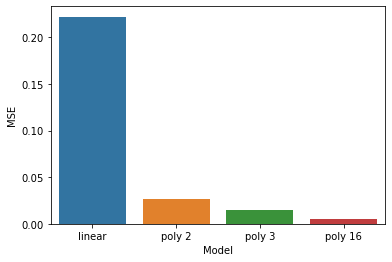

In [20]:
import seaborn as sb
sb.barplot(data=data, x='Model', y='MSE');

<AxesSubplot:xlabel='Model', ylabel='R2'>

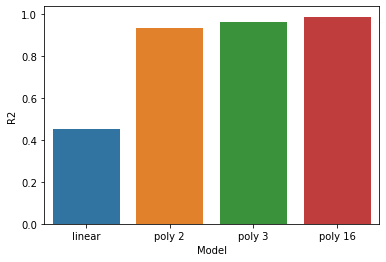

In [21]:
sb.barplot(data=data, x='Model', y='R2')

Obliczanie błędu MSE na danych `(X, Y)`, na których dokonano dopasowania modelu nie jest wiarygodną oceną. Widać, że model najbardziej złożony i przeuczony ma najmniejszy błąd MSE. Znając prawdziwą funkcję, możemy obliczyć błąd popełniany przez model, jednak w rzeczywistych zastosowaniach nie mamy dostępu do prawdziwej funkcji, gdyż to właśnie tą funkcję próbujemy odkryć. Potrzebujemy danych do testowania. W przypadku, gdy mamy do dyspozycji dużo danych wejściowych możemy je podzielić na część **treningową** oraz część **testową**. Wówczas model dopasowany na zbiorze treningowym może zostać oceniony na części testowej, która nie została użyta do stworzenia modelu. Jeżeli model regresyjny będzie posiadał mały błąd również na danych testowych to znaczy, że znaleźliśmy ogólną regułę, prawdziwą dla tego typu danych (tzn.model generalizuje).

### Ocena na danych testowych

Załóżmy, że posiadamy osobny fragment naszych wygenerowanych danych, który nie brał udziału w tworzeniu modelu. W naszym przypadku wygenerujemy nowe obserwacje, które posłużą w roli zbioru testowego.

In [22]:
x_test = np.sort(np.random.rand(100, 1))
y_test = true_function(x_test) + np.random.randn(100, 1) * 0.1

Dokonajmy oceny na zbiorze tesowym

,Model,MSE,R2,MSE test
0,linear,0.221991,0.452553,0.217249
1,poly 2,0.026898,0.933666,0.046159
2,poly 3,0.014699,0.963751,0.014370
3,poly 16,0.005255,0.987041,0.321886


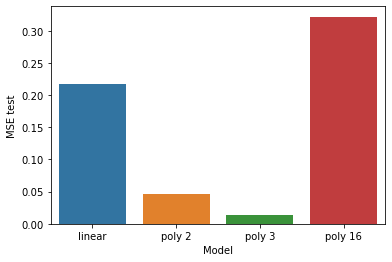

In [23]:
y_test_pred = regr.predict(x_test)
y_regr2_test_pred = regr2.predict(poly2.fit_transform(x_test))
y_regr3_test_pred = regr3.predict(poly3.fit_transform(x_test))
y_regr16_test_pred = regr16.predict(poly16.fit_transform(x_test))

mse_test = [ 
     mean_squared_error(y_test, y_test_pred),
     mean_squared_error(y_test, y_regr2_test_pred),
     mean_squared_error(y_test, y_regr3_test_pred),
     mean_squared_error(y_test, y_regr16_test_pred)
]

data['MSE test'] = mse_test
sb.barplot(data=data, x='Model', y='MSE test')
data

Jak można było się spodziewać model o największej złożoności (wielomian stopnia 16) ma największy błąd na zbiorze testowym. Na zbiorze treningowym jego błąd był bardzo mały, to znaczy, że model jest przeuczony i zbytnio dopasował się do danych w zbiorze uczącym. Najlepszą generalizację (zdolność do popranego przewidywania `y` na nowych danych) w tym wypadku miała regresja wielomianowa stopnia 3.


## Regularyzacja

Metody regularyzacji mają za zadanie zminimalizować ryzyko przeuczenia modelu. W przypadku regresji powszechnie stosowanym podejściem jest dodanie do funkcji kosztu $L$ dodatkowego członu, który będzie wymuszał zmniejszanie wartości wag $w_i$. W szczególnym wypadku, gdy waga zmaleje do zera $w_i=0$ można uznać, że zmienna $i$-ta jest nieistotna dla modelowanej zależności (czynnik $w_i x_{ij}$ zanika). W ten sposób wymuszając zmniejszanie wartości wag w trakcie optymalizacji preferowane są modele o mniejszej złożoności (część wag $w_i$ zaniknie lub będzie miała małe wartości).

### Regresja grzbietowa

Regresja grzbietowa (*Ridge regression*) polega poszukiwaniu parametrów $w_i$ poprzez minimalizację poniższej funkcji kosztu
$$L_{\textrm{ridge}} = \sum_{i=1}^N \|y_i - f(x_i)\|^2 + \alpha \|w\|^2 $$

gdzie $\alpha > 0$ jest parametrem określającym siłę regularyzacji.  
Dla $\alpha=0$ człon regularyzacyjny zanika i regresja grzbietowa zamienia się w zwykła regresję liniową. Zazwyczaj $\alpha$ jest małą wartością dodatnią np. 0.01.
Minimalizacja powyższej funkcji kosztu dąży do minimalizacji błędu MSE (pierwszy człon) oraz do zanikania wartości wag (drugi człon).

Spróbujmy zobaczyć jaki wynik uzyskamy dla regresji wielomianowej stopnia 16 w naszym przypadku, gdy zastosujemy regularyzację.

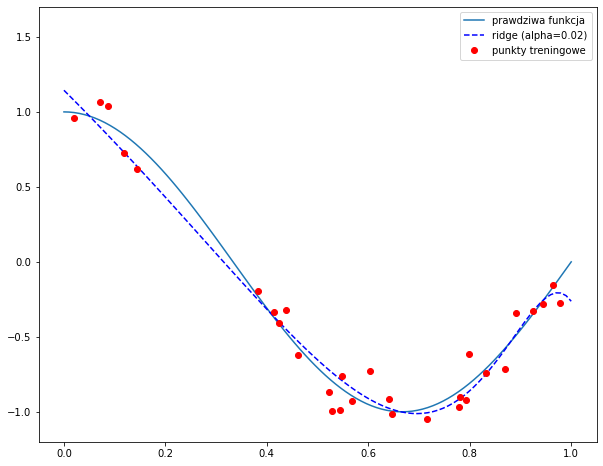

In [24]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.02)
ridge.fit(x_poly16, y)

plt.figure(figsize=(10, 8))

plt.plot(x_range, true_function(x_range), label='prawdziwa funkcja')
plt.plot(x_range, ridge.predict(poly16.fit_transform(x_range)), 'b--', label='ridge (alpha=0.02)')
# plt.plot(x_range, regr16.predict(poly16.fit_transform(x_range)), 'g--', label='poly 16')
plt.plot(x, y, 'ro', label='punkty treningowe')
plt.ylim((-1.2, 1.7))
plt.legend()
plt.show()


In [25]:
y_ridge_pred_test = ridge.predict(poly16.fit_transform(x_test))
y_ridge_pred_train = ridge.predict(poly16.fit_transform(x))
                             
data.loc[4] = ['ridge',  
               mean_squared_error(y, y_ridge_pred_train), 
               r2_score(y, y_ridge_pred_train),
               mean_squared_error(y_test, y_ridge_pred_test)] 
data

,Model,MSE,R2,MSE test
0,linear,0.221991,0.452553,0.217249
1,poly 2,0.026898,0.933666,0.046159
2,poly 3,0.014699,0.963751,0.014370
3,poly 16,0.005255,0.987041,0.321886
4,ridge,0.013255,0.967311,0.015515


<AxesSubplot:xlabel='Model', ylabel='MSE test'>

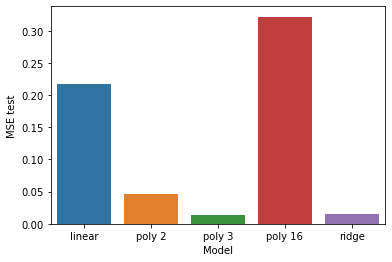

In [26]:
sb.barplot(data=data, x='Model', y='MSE test');

Błąd na zbiorze testowym wskazuje, że dopasowanie wielomianu stopnia 16 do naszego przykładu z zastosowaniem regularyzacji grzbietowej osiągnął zbliżony wynik do wielomianu stopnia 3. 

Zobaczmy jak wyglądają wartości bezwzględne uzyskanych parametrów $w_i$ dla modelu z regularyzacją i bez regularyzacji.

Suma wartości wag modelu z regularyzacją grzbietową: 11.532919903094758
Suma wartości wag modelu bez regularyzacji: 205633008081.48923


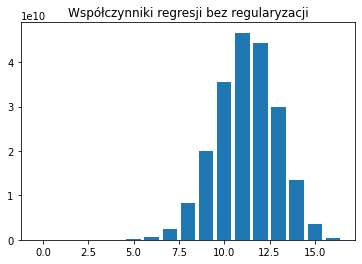

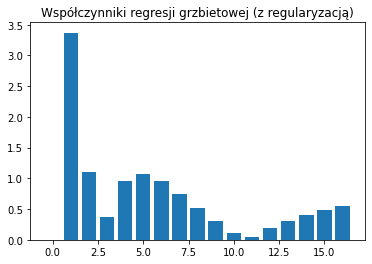

In [27]:
print('Suma wartości wag modelu z regularyzacją grzbietową:', np.absolute(ridge.coef_[0]).sum())
print('Suma wartości wag modelu bez regularyzacji:', np.absolute(regr16.coef_[0]).sum())

plt.bar(range(len(regr16.coef_[0])), np.absolute(regr16.coef_[0]))
plt.title('Współczynniki regresji bez regularyzacji')
plt.show()
plt.bar(range(len(ridge.coef_[0])), np.absolute(ridge.coef_[0]))
plt.title('Współczynniki regresji grzbietowej (z regularyzacją)')
plt.show()

### Regresja Lasso

Regresja metodą Lasso jest bardzo podobna do regresji grzbietowej, jednak zamiast normy $L_2$ w czynniku regularyzacyjnym występuje norma $L_1$:

$$L_{\textrm{lasso}} = \sum_{i=1}^N \|y_i - f(x_i)\|^2 + \alpha \|w\|_1 $$

Tego typu regularyzacja również preferuje rozwiązania z małymi wartościami wag, jednak w odróżnieniu od regresji grzbietowej otrzymana reprezentacja jest "rzadsza", tzn. większa liczba  spółczynników $w_i$ jest redukowanych do 0.

Wykonajmy ponownie dopasowanie wielomianem stopnia 16 tym razem z regularyzacją Lasso

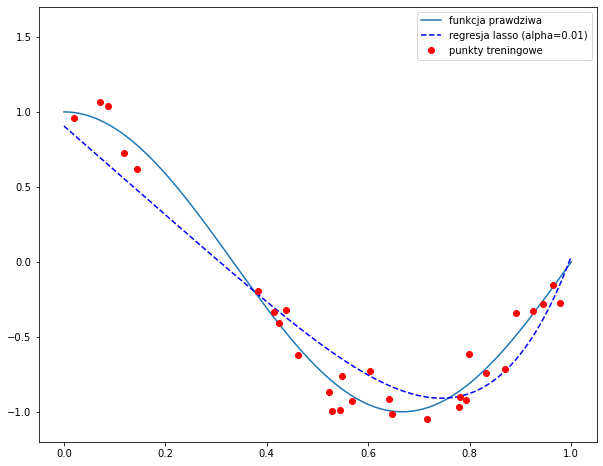

In [28]:
from sklearn.linear_model import Lasso
 
lasso = Lasso(alpha=0.01)
lasso.fit(x_poly16, y)

plt.figure(figsize=(10, 8))

plt.plot(x_range, true_function(x_range), label='funkcja prawdziwa')
plt.plot(x_range, lasso.predict(poly16.fit_transform(x_range)), 'b--', label='regresja lasso (alpha=0.01)')
# plt.plot(x_range, regr16.predict(poly16.fit_transform(x_range)), 'g--', label='poly 16')
plt.plot(x, y, 'ro', label='punkty treningowe')
plt.ylim((-1.2, 1.7))
plt.legend()
plt.show()                        



,Model,MSE,R2,MSE test
0,linear,0.221991,0.452553,0.217249
1,poly 2,0.026898,0.933666,0.046159
2,poly 3,0.014699,0.963751,0.014370
3,poly 16,0.005255,0.987041,0.321886
4,ridge,0.013255,0.967311,0.015515
5,lasso,0.037241,0.908161,0.041845


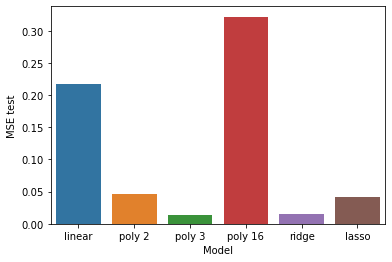

In [29]:
y_pred_train_lasso = lasso.predict(poly16.fit_transform(x))
y_pred_test_lasso = lasso.predict(poly16.fit_transform(x_test))

data.loc[5] = ['lasso',  
               mean_squared_error(y, y_pred_train_lasso), 
               r2_score(y, y_pred_train_lasso),
               mean_squared_error(y_test, y_pred_test_lasso)] 

sb.barplot(data=data, x='Model', y='MSE test')
data

Uzyskany wynik jest gorszy od modelu regresji grzbietowej ale jest też o wiele lepszy od modelu, który nie był poddany regularyzacji. Odpowiedni dobór siły regularyzacji $\alpha$ powinien pozwolić uzyskać wynik zbliżony a może i lepszy od regresji grzbietowej. 

Porównanie wartości współczynników uzyskanych obiema metodami regularyzacji.

Współczynniki modelu regresji grzbietowej
[ 0.         -3.36922377 -1.10633656  0.36832984  0.96184848  1.07278501
  0.95697453  0.75161136  0.52523058  0.30944119  0.11684498 -0.04927755
 -0.18990031 -0.30768992 -0.40576662 -0.48714508 -0.55451412]


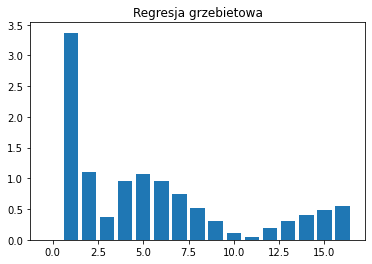

Współczynniki regresji modelu lasso
[ 0.         -2.96014903  0.          0.          0.          0.56434187
  1.52625552  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]


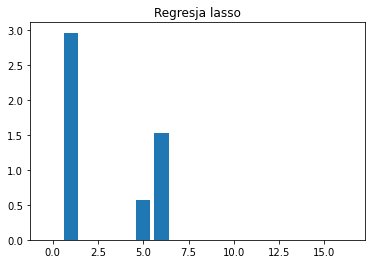

In [30]:
print('Współczynniki modelu regresji grzbietowej')
print(ridge.coef_[0])

plt.bar(range(len(ridge.coef_[0])), np.absolute(ridge.coef_[0]))
plt.title('Regresja grzebietowa')
plt.show()

print('Współczynniki regresji modelu lasso')
print(lasso.coef_)

plt.bar(range(len(lasso.coef_)), np.absolute(lasso.coef_))
plt.title('Regresja lasso')
plt.show()

W przypadku regularyzacji Lasso tylko 3 współczynniki są niezerowe, tzn. tylko te 3 zmienne wystarczą do uzyskania predykcji wartości `y` przy zachowaniu niewielkiego błędu.

# Zestaw danych Housing

Zbiór danych cen mieszkań w Bostonie (506 wierszy i 14 kolumn). Każdy wiersz reprezentuje dom znajdujący się w Bostonie w stanie Massachusetts w 1978 r.  
Celem jest oszacowania średniej wartości domu (MEDV). 

Źródło: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Atrybuty:
    
<pre>
1. CRIM      współczynnik przestępczości per capita na każde miasteczko
2. ZN        odsetek działek przekraczających 25 000 stóp kwadratowych (≈ 2533 metrów kwadratowych).
3. INDUS     odsetek terenów przeznaczonych na przemysł niedetaliczny na każde miasteczko
4. CHAS      zmienna zerojedynkowa określająca rzekę Charles (przyjmuje wartość 1, gdy na danym terenie znajduje się koryto      
             rzeki)
5. NOX       stężenie tlenków azotu (w częściach na 10 milionów)
6. RM        średnia liczba pomieszczeń na dom
7. AGE       odsetek zamieszkałych budynków wybudowanych przed 1940 rokiem
8. DIS       ważona odległość do pięciu bostońskich urzędów pracy
9. RAD       wskaźnik dostępności do głównych arterii komunikacyjnych
10. TAX      pełna wartość podatku od nieruchomości na każde 10 000 dolarów
11. PTRATIO  stosunek liczby uczniów do nauczycieli na każde miasteczko
12. B        parametr wyliczany ze wzoru 1000(Bk - 0.63)^2, gdzie Bk oznacza odsetek osób pochodzenia afroamerykańskiego 
             zamieszkujących dane miasteczko 
13. LSTAT    odsetek ubogiej części społeczeństwa
14. MEDV     mediana wartości zamieszkanych domów wyrażona w tysiącach dolarów
</pre>

In [31]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', 
                 header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Podstawowe informacje o danych

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


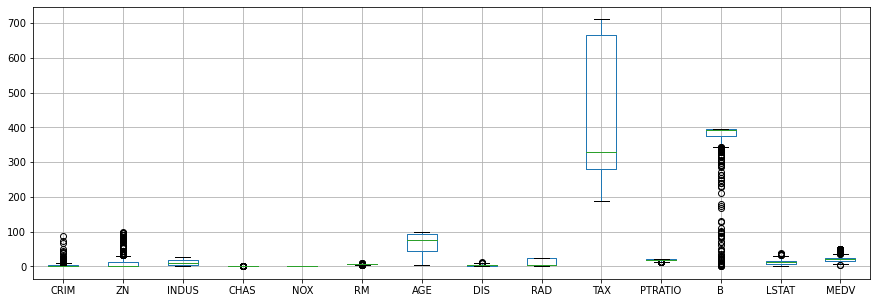

In [33]:
plt.figure(figsize=(15,5))
df.boxplot()
display(df.describe())

In [34]:
df.isna().any()

CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
MEDV       False
dtype: bool

## Wsółczynnik korelacji liniowej

Korelacja liniowa [Pearsona](https://pl.wikipedia.org/wiki/Wsp%C3%B3%C5%82czynnik_korelacji_Pearsona) 
$$
r_{x y}=\frac{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}} \sqrt{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}}
$$

Wartość bliska 1 lub -1 wskazuje o silnej korelacji linowej


In [35]:
#Sort correlations
correlations = df.corr()
correlations

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


<AxesSubplot:>

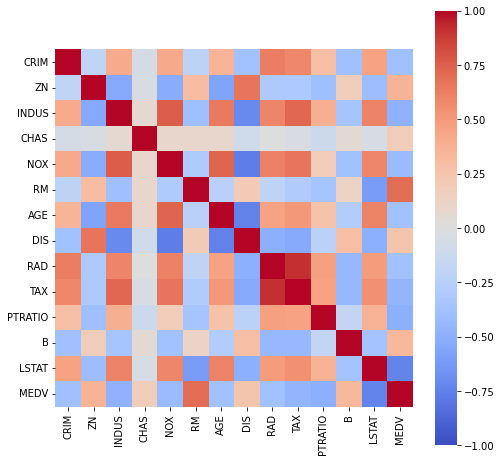

In [36]:
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(correlations, cmap='coolwarm', vmin=-1, vmax=1, square=True)

In [37]:
# Wspólczynniki korelacji dla zmiennej MEDV

corr_mdev = correlations['MEDV'].sort_values()
corr_mdev

LSTAT     -0.737663
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.388305
RAD       -0.381626
AGE       -0.376955
CHAS       0.175260
DIS        0.249929
B          0.333461
ZN         0.360445
RM         0.695360
MEDV       1.000000
Name: MEDV, dtype: float64

## Wizualizowanie ważnych elementów zestawu danych

Wybieżmy zmienne o wysokim wspólczynniku korelacji (>0.5)

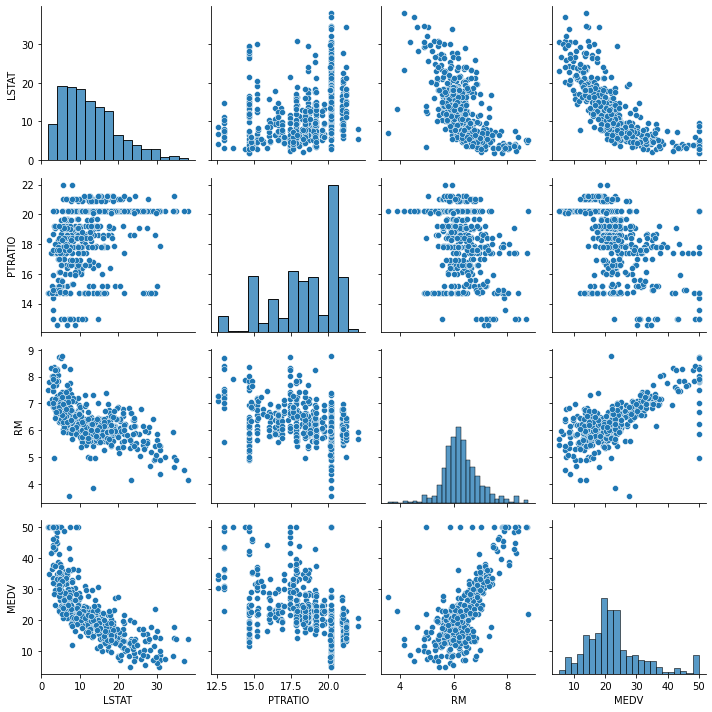

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['LSTAT', 'PTRATIO', 'RM', 'MEDV']

sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

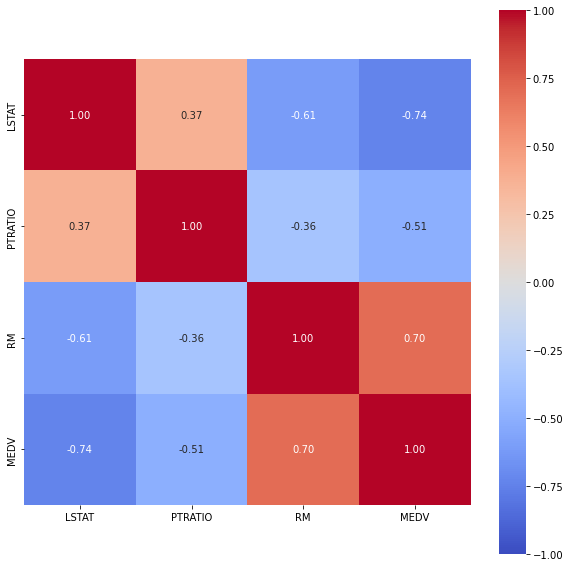

In [39]:
cm = df[cols].corr()
# sns.set(font_scale=1.0)
plt.figure(figsize=(10,10))
hm = sns.heatmap(cm, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 10},
            yticklabels=cols,
            xticklabels=cols,
            cmap='coolwarm', vmin=-1, vmax = 1)

plt.show()

## Wydzielenie zbioru testowego




In [40]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='MEDV')
y = df['MEDV']

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Ilość przypadków treningowych %d ' % len(X_train))
print('Ilość przypadków testowych    %d ' % len(X_test))

Ilość przypadków treningowych 354 
Ilość przypadków testowych    152 


## Model dla pojedynczej zmiennej

In [41]:
# from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train[['RM']],  y_train)

print('Nachylenie: %.3f' % lr.coef_[0])
print('Punkt przecięcia: %.3f' % lr.intercept_)

Nachylenie: 9.311
Punkt przecięcia: -35.994


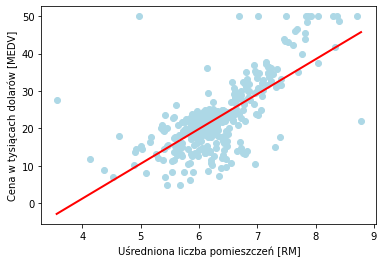

In [42]:
plt.scatter(X_train[['RM']], y_train, c='lightblue')

x_range = [X_train[['RM']].min().values, X_train[['RM']].max().values ]
plt.plot(x_range, lr.predict(x_range), color='red', linewidth=2) 

plt.xlabel('Uśredniona liczba pomieszczeń [RM]')
plt.ylabel('Cena w tysiącach dolarów [MEDV]')
plt.show()

In [43]:
num_rooms = [[ 5 ]]
price = lr.predict(num_rooms)
print("Cena w tysiącach dolarów: %.3f" % price)

Cena w tysiącach dolarów: 10.562


In [44]:
# ocena modelu
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_train_pred = lr.predict(X_train[['RM']])
y_test_pred = lr.predict(X_test[['RM']])

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)
print('MSE na próbkach uczących: %.3f, testowych: %.3f' % (mse_train, mse_test))

r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)
print('Współczynnik R^2 dla danych uczących: %.3f, testowych: %.3f' % (r2_train, r2_test))

MSE na próbkach uczących: 42.158, testowych: 47.033
Współczynnik R^2 dla danych uczących: 0.503, testowych: 0.435


In [45]:
wyniki = pd.DataFrame(columns =['MSE train', 'MSE test', 'R2 train', 'R2 test' ])
wyniki.loc['LR zmienna [RM]'] = [mse_train, mse_test, r2_train, r2_test ]
wyniki

,MSE train,MSE test,R2 train,R2 test
LR zmienna [RM],42.157651,47.033047,0.50265,0.435144


## Model regresji liniowej dla wybranych zmiennych


In [46]:
# wybierzmy 3 zmienne o najwiekszym wsp. korelacji
cols = ['LSTAT', 'PTRATIO', 'RM']

lr = LinearRegression()
lr.fit(X_train[cols],  y_train)

y_train_pred = lr.predict(X_train[cols])
y_test_pred = lr.predict(X_test[cols])

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)

wyniki.loc['LR zmienne %s' % str(cols)] = [ mse_train, mse_test, r2_train, r2_test ]
wyniki

,MSE train,MSE test,R2 train,R2 test
LR zmienna [RM],42.157651,47.033047,0.502650,0.435144
"LR zmienne ['LSTAT', 'PTRATIO', 'RM']",24.611034,33.426174,0.709654,0.598559


## Wykres residuów (wartości resztowe)

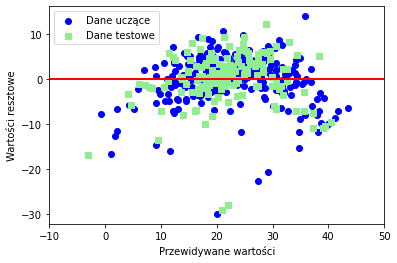

In [47]:
plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Dane uczące')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Dane testowe')
plt.xlabel('Przewidywane wartości')
plt.ylabel('Wartości resztowe')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])

plt.show()

## Model regresji dla wszystkich zmienneych

In [48]:
lr = LinearRegression()
lr.fit(X_train,  y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)

wyniki.loc['LR wszystkie zmienne'] = [ mse_train, mse_test, r2_train, r2_test ]
wyniki

,MSE train,MSE test,R2 train,R2 test
LR zmienna [RM],42.157651,47.033047,0.502650,0.435144
"LR zmienne ['LSTAT', 'PTRATIO', 'RM']",24.611034,33.426174,0.709654,0.598559
LR wszystkie zmienne,19.958220,27.195966,0.764545,0.673383


In [49]:
# lasso dla wszystkich zmiennych 
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)

wyniki.loc['Lasso wszystkie zmienne'] = [ mse_train, mse_test, r2_train, r2_test ]
wyniki

[-0.06586193  0.04832933 -0.          0.         -0.          0.86898466
  0.01217999 -0.75109378  0.2000743  -0.01395062 -0.84602363  0.00668818
 -0.73266568]


,MSE train,MSE test,R2 train,R2 test
LR zmienna [RM],42.157651,47.033047,0.502650,0.435144
"LR zmienne ['LSTAT', 'PTRATIO', 'RM']",24.611034,33.426174,0.709654,0.598559
LR wszystkie zmienne,19.958220,27.195966,0.764545,0.673383
Lasso wszystkie zmienne,24.716523,32.345039,0.708410,0.611543


In [50]:
# silniejsza regularyzacja lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

wyniki.loc['Lasso alpha=0.1 wszystkie zmienne'] = [ mean_squared_error(y_train, y_train_pred), 
                                                   mean_squared_error(y_test, y_test_pred), 
                                                   r2_score(y_train, y_train_pred), 
                                                   r2_score(y_test, y_test_pred) ]
wyniki

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


,MSE train,MSE test,R2 train,R2 test
LR zmienna [RM],42.157651,47.033047,0.502650,0.435144
"LR zmienne ['LSTAT', 'PTRATIO', 'RM']",24.611034,33.426174,0.709654,0.598559
LR wszystkie zmienne,19.958220,27.195966,0.764545,0.673383
Lasso wszystkie zmienne,24.716523,32.345039,0.708410,0.611543
Lasso alpha=0.1 wszystkie zmienne,20.926031,28.875759,0.753127,0.653209


## Modelowanie nieliniowych zależności

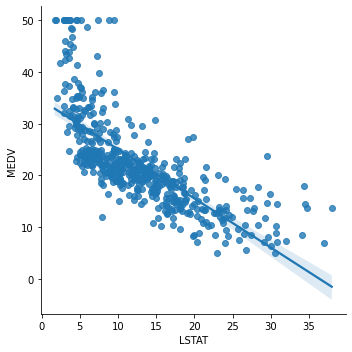

In [51]:
# zmienna 'LSTAT'

sns.lmplot(data=df, x='LSTAT', y='MEDV');

In [52]:
from sklearn.preprocessing import PolynomialFeatures 

# tworzy wielomianowe cechy
quadratic = PolynomialFeatures(degree=2)
X_quad_train = quadratic.fit_transform(X_train[['LSTAT']])

lr = LinearRegression()
lr.fit(X_quad_train, y_train)

y_train_pred = lr.predict(X_quad_train)
y_test_pred = lr.predict(quadratic.transform(X_test[['LSTAT']]))

wyniki.loc['LR kwadratowe (d=2) [LSTAT]'] = [ mean_squared_error(y_train, y_train_pred), 
                                              mean_squared_error(y_test, y_test_pred), 
                                              r2_score(y_train, y_train_pred), 
                                              r2_score(y_test, y_test_pred) ]
wyniki

,MSE train,MSE test,R2 train,R2 test
LR zmienna [RM],42.157651,47.033047,0.502650,0.435144
"LR zmienne ['LSTAT', 'PTRATIO', 'RM']",24.611034,33.426174,0.709654,0.598559
LR wszystkie zmienne,19.958220,27.195966,0.764545,0.673383
Lasso wszystkie zmienne,24.716523,32.345039,0.708410,0.611543
Lasso alpha=0.1 wszystkie zmienne,20.926031,28.875759,0.753127,0.653209
LR kwadratowe (d=2) [LSTAT],29.000487,33.602395,0.657870,0.596443


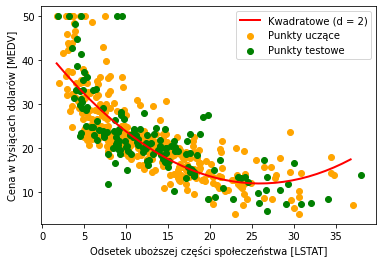

In [53]:
X_fit = np.arange(X_train[['LSTAT']].values.min(), X_train[['LSTAT']].values.max(), 1)[:, np.newaxis]
y_quad_fit = lr.predict(quadratic.transform(X_fit))

# tworzy wynikowy wykres
plt.scatter(X_train[['LSTAT']], y_train, label='Punkty uczące', color='orange')
plt.scatter(X_test[['LSTAT']], y_test, label='Punkty testowe', color='green')

plt.plot(X_fit, y_quad_fit, 
         label='Kwadratowe (d = 2)',
         color='red', 
         lw=2,
         linestyle='-')

plt.xlabel('Odsetek uboższej części społeczeństwa [LSTAT]')
plt.ylabel('Cena w tysiącach dolarów [MEDV]')
plt.legend(loc='upper right')

In [54]:
# przekształcenie cechy (zmiennej) aby uzyskać liniowaą zalezność
X_log_train = np.log(X_train[['LSTAT']].values)

lr.fit(X_log_train, y_train)

lr = LinearRegression()
lr.fit(X_log_train, y_train)

y_train_pred = lr.predict(X_log_train)
y_test_pred = lr.predict(np.log(X_test[['LSTAT']]))

wyniki.loc['LR log([LSTAT])'] = [ mean_squared_error(y_train, y_train_pred), 
                                  mean_squared_error(y_test, y_test_pred), 
                                  r2_score(y_train, y_train_pred), 
                                  r2_score(y_test, y_test_pred) ]
wyniki

,MSE train,MSE test,R2 train,R2 test
LR zmienna [RM],42.157651,47.033047,0.502650,0.435144
"LR zmienne ['LSTAT', 'PTRATIO', 'RM']",24.611034,33.426174,0.709654,0.598559
LR wszystkie zmienne,19.958220,27.195966,0.764545,0.673383
Lasso wszystkie zmienne,24.716523,32.345039,0.708410,0.611543
Lasso alpha=0.1 wszystkie zmienne,20.926031,28.875759,0.753127,0.653209
LR kwadratowe (d=2) [LSTAT],29.000487,33.602395,0.657870,0.596443
LR log([LSTAT]),27.340297,30.492814,0.677456,0.633788


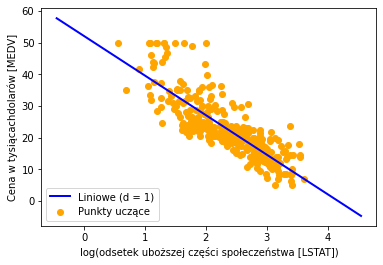

In [55]:
X_fit = np.arange(X_log_train.min()-1, X_log_train.max()+1, 1)[:, np.newaxis]
y_fit = lr.predict(X_fit)

plt.scatter(X_log_train, y_train, label='Punkty uczące', color='orange')

plt.plot(X_fit, y_fit, 
         label='Liniowe (d = 1)', 
         color='blue', 
         lw=2)

plt.xlabel('log(odsetek uboższej części społeczeństwa [LSTAT])')
plt.ylabel('Cena w tysiącachdolarów [MEDV]')
plt.legend(loc='lower left')

## Zadanie 

Pod adresem https://www.fizyka.umk.pl/~grochu/wdm/files/diabetes.csv znajduje się plik zawierający dane `n=442` pacjentów chorych na cukrzycę (`diabetes`). Każdy przypadek opisany jest 10 zmiennymi numerycznymi:  wiek (`AGE`), płeć (`SEX`), wskaźnik masy ciała (`BMI`), średnie ciśnienie krwi (`BP`) i sześć pomiarów surowicy krwi (`S1 S2 S3 S4 S5 S6`). Ostatnia kolumna (zmienna `Y`) zawiera wartości określające stopnień zaawansowania choroby. Zadanie polega na zbudowaniu modeli regresji liniowej przewidujących wartość zmiennej `Y` zgodnie z poniższymi wytycznymi.

1. Wczytaj plik i sprawdź, czy w danych występują braki oraz sprawdź, czy wszystkie zmienne są wartościami numerycznymi. Jeżeli zajdzie potrzeba usuń obserwacje zawierające braki a zmienne przetransformuj do postaci numerycznej.

2. Podziel dane na dwie części: treningową zawierającą 75% przypadków i testową zawierającą pozostałe 25% przypadków.   
Modele regresji trenuj wyłacznie na części treningowej.  
Do podziału danych możesz wykorzystać funkcję [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) z pakietu scikit-learn.

3. Sporządź wykres parowy [pairplot()](https://seaborn.pydata.org/generated/seaborn.pairplot.html) zbioru treningowego i na jego podstawie wybierz jedną zmienną, która wydaje się posiadać liniową zależność względem zmiennej wyjściowej `Y`. Zbuduj model regresji liniowej dla wybranej zmiennej i wyznacz błąd MSE predykcji `Y` na zbiorze treningowym oraz na zbiorze testowym.

4. Zbuduj model regresji liniowej wielowymiarowej uwzględniając wszystkie zmienne do opisu zmiennej wyjściowej `Y`. Zastosuj w tym celu jedną, wybraną metodę z regularyacją (np. grzbietową lub Lasso). Przeprowadź obliczenia dla przynajmniej 2 róznych wartości współczynnika określającego siłę regularyzacji $\alpha$ i porównaj wyniki. 

5. Spośród stworzonych modeli regresji wybierz najlepszy (ten o najmniejszym MSE na zbiorze testowym) i wypisz (lub wyświetl) jego współczynniki regresji.